In [1]:
import subprocess
import os

result = subprocess.run('bash -c "source /etc/network_turbo && env | grep proxy"', shell=True, capture_output=True, text=True)
output = result.stdout
for line in output.splitlines():
    if '=' in line:
        var, value = line.split('=', 1)
        os.environ[var] = value

In [2]:
!pip install numpy pandas matplotlib seaborn scikit-learn torch torchvision

Looking in indexes: http://mirrors.aliyun.com/pypi/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 71.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 117.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 96.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.2/509.2 kB 121.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.8/347.8 kB 129.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.1/35.1 MB 75.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 118.7 MB/s eta 0:00:00


In [7]:
# Hourly Energy Consumption Dataset in Kaggle: https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption/data?select=PJME_hourly.csv

import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

📊 Loading real energy consumption data from: PJME_hourly.csv...
✅ Data loaded successfully!

🔍 Starting energy data analysis
Dataset shape: (145366, 2)
Time range: 2002-01-01 01:00:00 to 2018-08-03 00:00:00
Total missing values: 0

📊 Data Statistics Summary:
count    145366.000000
mean      32080.222831
std        6464.012166
min       14544.000000
25%       27573.000000
50%       31421.000000
75%       35650.000000
max       62009.000000
Name: PJME_MW, dtype: float64


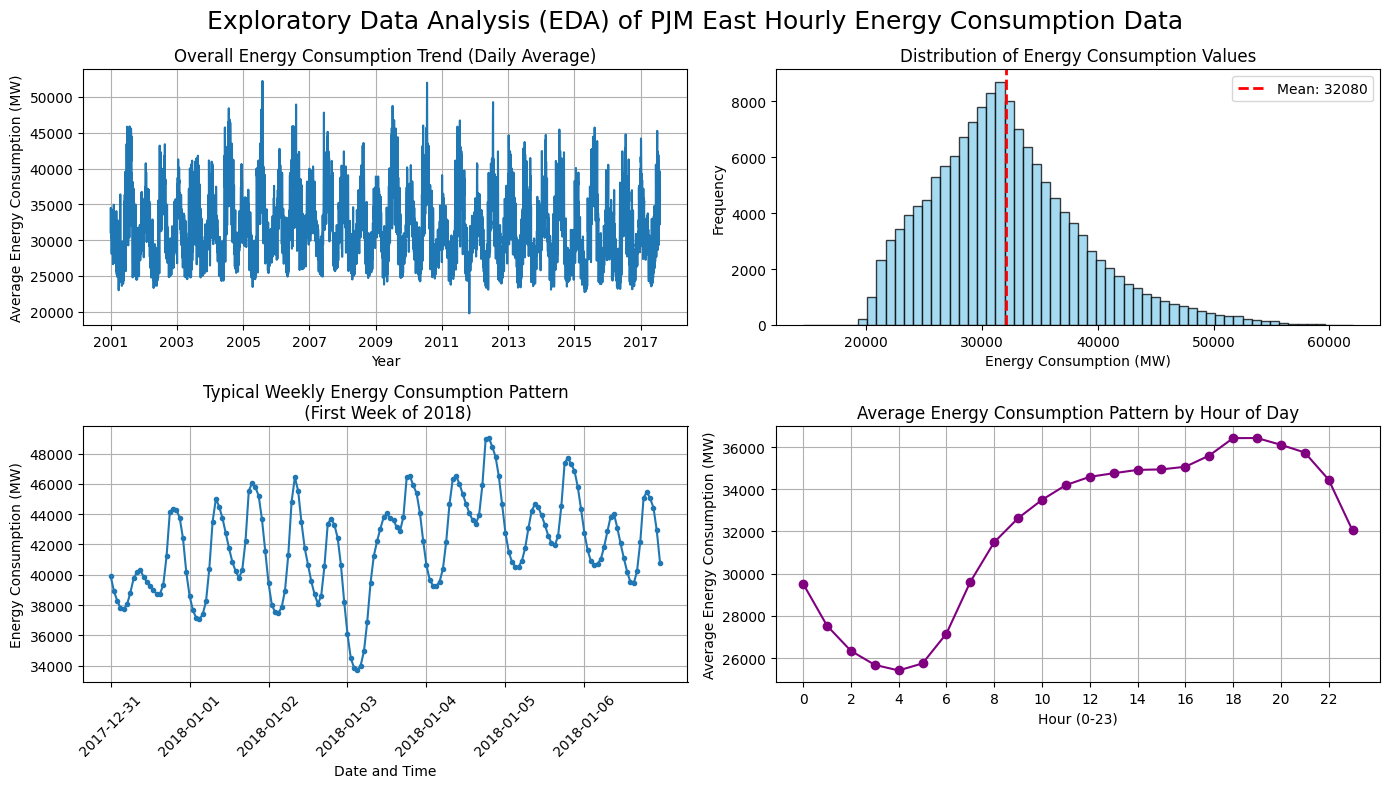


--- Data Preview (first 5 rows) ---
             Datetime  PJME_MW  Hour
0 2002-12-31 01:00:00  26498.0     1
1 2002-12-31 02:00:00  25147.0     2
2 2002-12-31 03:00:00  24574.0     3
3 2002-12-31 04:00:00  24393.0     4
4 2002-12-31 05:00:00  24860.0     5


In [3]:
DATASET_PATH = "/root/hourly-energy-consumption"

def load_energy_data(base_path, filename='PJME_hourly.csv'):
    """Loads and preprocesses real hourly energy consumption data from the specified path"""

    print(f"📊 Loading real energy consumption data from: {filename}...")

    # Construct the full file path
    file_path = os.path.join(base_path, filename)

    try:
        # Read the CSV file
        df = pd.read_csv(file_path)

        # Convert the 'Datetime' column to datetime objects, which is crucial for time series analysis
        df['Datetime'] = pd.to_datetime(df['Datetime'])

        print("✅ Data loaded successfully!")
        return df

    except FileNotFoundError:
        print(f"❌ Error: File not found! Please check if the path is correct: {file_path}")
        return None

def analyze_energy_data(df):
    """Performs comprehensive exploratory analysis on energy consumption data"""

    if df is None:
        print("Data could not be loaded, analysis aborted.")
        return None

    print("\n🔍 Starting energy data analysis")
    print("=" * 50)
    print(f"Dataset shape: {df.shape}")
    print(f"Time range: {df['Datetime'].min()} to {df['Datetime'].max()}")
    print(f"Total missing values: {df.isnull().sum().sum()}")

    print("\n📊 Data Statistics Summary:")
    print(df['PJME_MW'].describe())

    # Set global font size for clearer plots
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))
    fig.suptitle('Exploratory Data Analysis (EDA) of PJM East Hourly Energy Consumption Data', fontsize=18)

    # 1. Full Time Series Plot (for clarity, data can be downsampled, e.g., by day)
    df_daily_sample = df.set_index('Datetime').resample('D').mean()
    axes[0, 0].plot(df_daily_sample.index, df_daily_sample['PJME_MW'],
                    label='Daily Average Energy Consumption')
    axes[0, 0].set_title('Overall Energy Consumption Trend (Daily Average)')
    axes[0, 0].set_xlabel('Year')
    axes[0, 0].set_ylabel('Average Energy Consumption (MW)')
    axes[0, 0].grid(True)

    # 2. Histogram of Energy Consumption Values
    axes[0, 1].hist(df['PJME_MW'], bins=60, alpha=0.75, color='skyblue',
                    edgecolor='black')
    axes[0, 1].set_title('Distribution of Energy Consumption Values')
    axes[0, 1].set_xlabel('Energy Consumption (MW)')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].axvline(df['PJME_MW'].mean(), color='r', linestyle='--',
                       linewidth=2, label=f"Mean: {df['PJME_MW'].mean():.0f}")
    axes[0, 1].legend()

    # 3. Weekly Pattern (example using the first week of 2018)
    sample_week = df[(df['Datetime'] >= '2018-01-01') & (df['Datetime'] < '2018-01-08')].sort_values(by='Datetime')
    axes[1, 0].plot(sample_week['Datetime'], sample_week['PJME_MW'], marker='.', linestyle='-')
    axes[1, 0].set_title('Typical Weekly Energy Consumption Pattern\n (First Week of 2018)')
    axes[1, 0].set_xlabel('Date and Time')
    axes[1, 0].set_ylabel('Energy Consumption (MW)')
    axes[1, 0].grid(True)
    axes[1, 0].tick_params(axis='x', rotation=45)

    # 4. Average Daily Pattern (aggregated across all data)
    df['Hour'] = df['Datetime'].dt.hour
    hourly_avg = df.groupby('Hour')['PJME_MW'].mean()
    axes[1, 1].plot(hourly_avg.index, hourly_avg.values, marker='o', color='purple')
    axes[1, 1].set_title('Average Energy Consumption Pattern by Hour of Day')
    axes[1, 1].set_xlabel('Hour (0-23)')
    axes[1, 1].set_ylabel('Average Energy Consumption (MW)')
    axes[1, 1].grid(True)
    axes[1, 1].set_xticks(np.arange(0, 24, 2)) # Set ticks every 2 hours

    plt.tight_layout()
    plt.show()

    return df

# --- 4. Execute Loading and Analysis ---
# Load data from the specified PATH
df = load_energy_data(DATASET_PATH, filename='PJME_hourly.csv')

# Analyze the loaded real data
df = analyze_energy_data(df)

# If data was loaded successfully, display the first few rows
if df is not None:
    print("\n--- Data Preview (first 5 rows) ---")
    print(df.head())

In [ ]:
class EnergyDataPreprocessor:
    """Comprehensive data preprocessing for energy consumption prediction"""

    def __init__(self, sequence_length=24, prediction_horizon=1):
        self.sequence_length = sequence_length  # Look back 24 hours
        self.prediction_horizon = prediction_horizon  # Predict 1 hour ahead
        # X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0)) 
        # X_scaled = X_std * (max - min) + min
        self.scaler = MinMaxScaler() 

    def create_features(self, df):
        """Create time-based features"""
        df = df.copy()
        df['Hour'] = df['Datetime'].dt.hour
        df['DayOfWeek'] = df['Datetime'].dt.dayofweek
        df['Month'] = df['Datetime'].dt.month
        df['IsWeekend'] = (df['DayOfWeek'] >= 5).astype(int)

        # Cyclical encoding for time features
        df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
        df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
        df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
        df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

        return df

    def create_sequences(self, data, target_col='PJME_MW'):
        """Create sequences for RNN training"""
        print(f"1. The shape of data: {data.shape},\nColumns: ")

        columns = data.columns.tolist()
        for i in range(0, len(columns), 5):
            print(columns[i:i + 5]) 

        # Select features for modeling
        feature_cols = [target_col, 'Hour_sin', 'Hour_cos', 'Month_sin', 'Month_cos', 'IsWeekend']
        data_features = data[feature_cols].values

        # Normalize the data
        scaled_data = self.scaler.fit_transform(data_features)
        print(f"\n2. The shape of scaled_data: {scaled_data.shape}\nColumns: {feature_cols}")
        print(f"\nThe sample data of scaled_data: \n{scaled_data[:5]}")
             
        sequences = []
        targets = []

        for i in range(len(scaled_data) - self.sequence_length - self.prediction_horizon + 1):
            # Input sequence
            seq = scaled_data[i:(i + self.sequence_length)]
            # Target (only the energy consumption value)
            target = scaled_data[i + self.sequence_length : i + self.sequence_length + self.prediction_horizon, 0]

            sequences.append(seq)
            targets.append(target)

        return np.array(sequences), np.array(targets)

    def train_test_split(self, sequences, targets, train_ratio=0.8):
        """Split data into train and test sets"""
        split_idx = int(len(sequences) * train_ratio)

        X_train = sequences[:split_idx]
        X_test = sequences[split_idx:]
        y_train = targets[:split_idx]
        y_test = targets[split_idx:]

        print("\n3. The shape of splitted dataset: ")
        print(f"Training data shape: {X_train.shape}")
        print(f"Training targets shape: {y_train.shape}")
        print(f"Test data shape: {X_test.shape}")
        print(f"Test targets shape: {y_test.shape}")

        return X_train, X_test, y_train, y_test

# Preprocess the data
preprocessor = EnergyDataPreprocessor(sequence_length=24, prediction_horizon=1)

df_features = preprocessor.create_features(df)
sequences, targets = preprocessor.create_sequences(df_features)
print(f"\nThe shape of sequences: {sequences.shape}, targets: {targets.shape}")

X_train, X_test, y_train, y_test = preprocessor.train_test_split(sequences, targets)

In [22]:
class EnergyDataset(Dataset):
    """Custom dataset for energy consumption data"""

    def __init__(self, sequences, targets):
        self.sequences = torch.FloatTensor(sequences)
        self.targets = torch.FloatTensor(targets)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.targets[idx]

class BasicRNN(nn.Module):
    """Basic RNN implementation in PyTorch"""

    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(BasicRNN, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # RNN layer
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True, # (batch_size, sequence_length, input_size)
            dropout=dropout if num_layers > 1 else 0
        )

        # Output layer
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Initialize hidden state
        # x.shape: (batch_size, sequence_length, input_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward pass through RNN
        rnn_out, _ = self.rnn(x, h0)

        # Take the output from the last time step
        last_output = rnn_out[:, -1, :]

        # Apply dropout and fully connected layer
        output = self.dropout(last_output)
        output = self.fc(output)

        return output

🔢 RNN Model Parameters: 462,593

🚀 Training Basic RNN on cuda
Epoch [01/50] | Train Loss: 0.003501 | Val Loss: 0.000482 | LR: 0.001000 | Time: 2.67s
Epoch [02/50] | Train Loss: 0.000918 | Val Loss: 0.000406 | LR: 0.001000 | Time: 2.59s
Epoch [03/50] | Train Loss: 0.000787 | Val Loss: 0.000441 | LR: 0.001000 | Time: 2.45s
Epoch [04/50] | Train Loss: 0.000690 | Val Loss: 0.000711 | LR: 0.001000 | Time: 2.42s
Epoch [05/50] | Train Loss: 0.000670 | Val Loss: 0.000357 | LR: 0.001000 | Time: 2.60s
Epoch [06/50] | Train Loss: 0.000632 | Val Loss: 0.000400 | LR: 0.001000 | Time: 2.52s
Epoch [07/50] | Train Loss: 0.000615 | Val Loss: 0.000444 | LR: 0.001000 | Time: 2.17s
Epoch [08/50] | Train Loss: 0.000625 | Val Loss: 0.000674 | LR: 0.001000 | Time: 2.57s
Epoch [09/50] | Train Loss: 0.000585 | Val Loss: 0.000489 | LR: 0.001000 | Time: 2.66s
Epoch [10/50] | Train Loss: 0.000594 | Val Loss: 0.000831 | LR: 0.001000 | Time: 2.25s
Epoch [11/50] | Train Loss: 0.000559 | Val Loss: 0.000491 | LR: 0.00

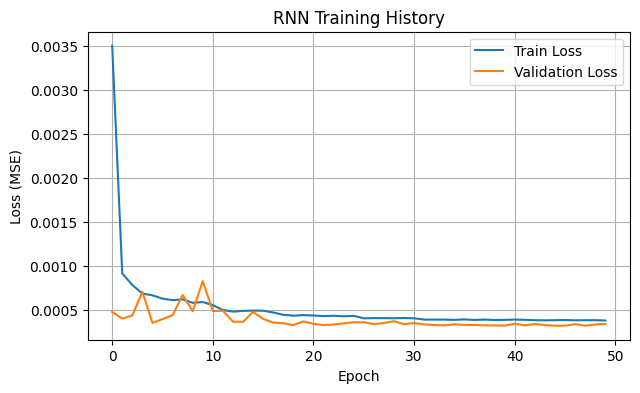

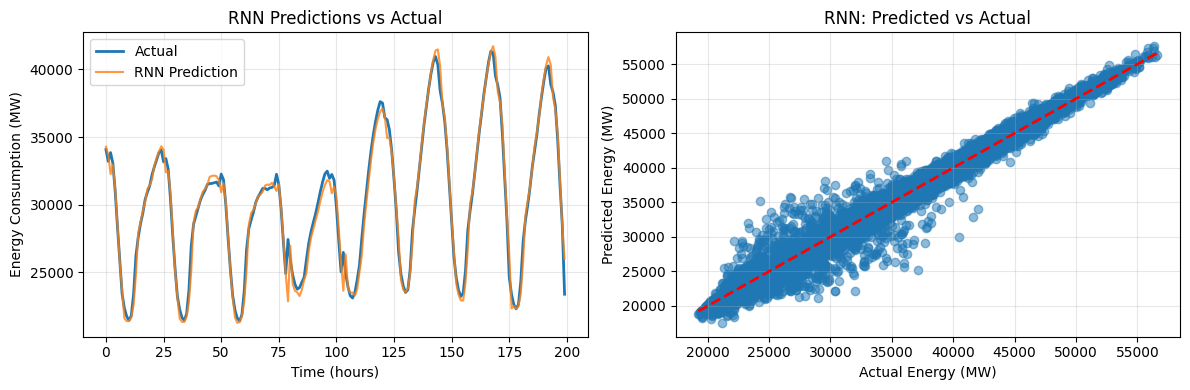

In [29]:
def train_model(model, train_loader, val_loader, num_epochs, learning_rate, model_name):
    """Train the RNN model"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)

    total_train_time = 0.0
    train_losses, val_losses = [], []
    print(f"🚀 Training {model_name} on {device}")
    print("=" * 50)
    
    for epoch in range(num_epochs):
        epoch_start_time = time.time() 
        model.train()
        train_loss = 0.0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs.squeeze(), batch_y.squeeze())
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()
            
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = model(batch_x)
                loss = criterion(outputs.squeeze(), batch_y.squeeze())
                val_loss += loss.item()
                
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        scheduler.step(avg_val_loss)

        epoch_end_time = time.time()
        time_taken = epoch_end_time - epoch_start_time
        total_train_time += time_taken
        print(f'Epoch [{epoch+1:02d}/{num_epochs}] | '
              f'Train Loss: {avg_train_loss:.6f} | '
              f'Val Loss: {avg_val_loss:.6f} | '
              f'LR: {optimizer.param_groups[0]["lr"]:.6f} | '
              f'Time: {time_taken:.2f}s')
    print(f'Total train time: {total_train_time}')
    return model, train_losses, val_losses

def evaluate_model(model, test_loader, preprocessor, model_name):
    """Evaluate the trained model"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    
    predictions, actuals = [], []
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(batch_y.cpu().numpy())
            
    predictions = np.array(predictions).flatten()
    actuals = np.array(actuals).flatten()
    
    dummy_features = np.zeros((len(predictions), preprocessor.scaler.n_features_in_))
    dummy_features[:, 0] = predictions
    predictions_original = preprocessor.scaler.inverse_transform(dummy_features)[:, 0]
    dummy_features[:, 0] = actuals
    actuals_original = preprocessor.scaler.inverse_transform(dummy_features)[:, 0]
    
    mse = mean_squared_error(actuals_original, predictions_original)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals_original, predictions_original)
    mape = np.mean(np.abs((actuals_original - predictions_original) / actuals_original)) * 100
    
    print(f"\n📊 {model_name} Evaluation Results")
    print("=" * 40)
    print(f"RMSE (Root Mean Squared Error): {rmse:.2f} MW")
    print(f"MAE  (Mean Absolute Error): {mae:.2f} MW")
    print(f"MAPE (Mean Absolute Percentage Error): {mape:.2f}%")
    return predictions_original, actuals_original

def plot_training_history(train_losses, val_losses):
    plt.figure(figsize=(7, 4))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('RNN Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_predictions(predictions, actuals, num_points=200):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    time_points = range(num_points)
    axes[0].plot(time_points, actuals[:num_points], label='Actual', linewidth=2)
    axes[0].plot(time_points, predictions[:num_points], label='RNN Prediction', alpha=0.8)
    axes[0].set_title('RNN Predictions vs Actual')
    axes[0].set_xlabel('Time (hours)')
    axes[0].set_ylabel('Energy Consumption (MW)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    axes[1].scatter(actuals, predictions, alpha=0.5)
    axes[1].plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], 'r--', lw=2)
    axes[1].set_title('RNN: Predicted vs Actual')
    axes[1].set_xlabel('Actual Energy (MW)')
    axes[1].set_ylabel('Predicted Energy (MW)')
    axes[1].grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# datasets preparation
train_dataset = EnergyDataset(X_train, y_train)
test_dataset = EnergyDataset(X_test, y_test)

val_split = int(0.8 * len(train_dataset))
train_subset, val_subset = torch.utils.data.random_split(train_dataset, [val_split, len(train_dataset) - val_split])

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# init parameters
input_size = X_train.shape[2]
hidden_size = 256
num_layers = 4
output_size = 1
learning_rate = 0.001
batch_size = 256
num_epochs = 50

# build the RNN and train the model
rnn_model = BasicRNN(input_size, hidden_size, num_layers, output_size)
print(f"🔢 RNN Model Parameters: {sum(p.numel() for p in rnn_model.parameters()):,}\n")

rnn_trained, rnn_train_losses, rnn_val_losses = train_model(
    rnn_model, train_loader, val_loader, num_epochs, learning_rate, "Basic RNN"
)

rnn_preds, rnn_actuals = evaluate_model(rnn_trained, test_loader, preprocessor, "Basic RNN")
plot_training_history(rnn_train_losses, rnn_val_losses)
plot_predictions(rnn_preds, rnn_actuals)